In [2]:

import pandas as pd
import matplotlib.pyplot  as plt

import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.grid"] = False

In [6]:
balldf = pd.read_csv("IPL Ball-by-Ball 2008-2020.csv")
matches = pd.read_csv("IPL Matches 2008-2020.csv")

In [7]:
balldf.head(3)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [8]:
matches.head(3)

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar


In [9]:
balldf.shape

(193468, 18)

In [10]:
matches.shape

(816, 17)

In [11]:
balldf.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

In [12]:
# Group details on batsmen
batgroup = balldf.groupby(['batsman'])

# Create a batting dataframe with a summary statistics for each batsman
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)

In [13]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of no. of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [14]:
display(batdf.tail())

,balls_faced,innings,runs,4s,6s,bat_average
batsman,,,,,,
YV Takawale,183,10,192,26.0,3.0,19.20
Yashpal Singh,67,4,47,5.0,0.0,11.75
Younis Khan,7,1,3,0.0,0.0,3.00
Yuvraj Singh,2205,126,2750,217.0,149.0,21.83
Z Khan,141,27,117,11.0,2.0,4.33


In [15]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [16]:
# Group details on bowler
bowlgroup = balldf.groupby(['bowler'])

# Create a bowling dataframe (bowldf) with a summary statistics for each batsman
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['over'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [17]:
display(bowldf.tail())

,balls_bowled,wickets,overs,runs_conceded,bowl_econ
bowler,,,,,
YA Abdulla,222,15.0,35,307.0,8.77
YK Pathan,1184,42.0,193,1415.0,7.33
YS Chahal,2188,121.0,359,2723.0,7.58
Yuvraj Singh,882,36.0,146,1077.0,7.38
Z Khan,2276,102.0,371,2782.0,7.50


In [18]:
# Add each player to the final all players list
def update_player_with_match(player_name, id):
    if player_name in all_players_dict:
        all_players_dict[player_name].add(id)
    else:
        all_players_dict[player_name] = {id}

# Consider players listed as batsman, non striker or bowler
def update_player_list(x):
    update_player_with_match(x['batsman'],x['id'])
    update_player_with_match(x['non_striker'],x['id'])
    update_player_with_match(x['bowler'],x['id'])

# Create a dataframe with all players list
all_players_dict = {}
out_temp = balldf.apply(lambda x: update_player_list(x),axis=1)
all_df = pd.DataFrame({'Players':list(all_players_dict.keys())})
all_df['matches'] = all_df['Players'].apply(lambda x: len(all_players_dict[x]))
all_df=all_df.set_index('Players')

In [19]:
# Combine the batting and bowling dataframes to create a merged players dataframe
players = pd.merge(all_df,batdf, left_index=True, right_index=True,how='outer')
players = pd.merge(players,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

players.tail()

,matches,balls_faced,innings,runs,4s,6s,bat_average,balls_bowled,wickets,overs,runs_conceded,bowl_econ
YV Takawale,10,183.0,10.0,192.0,26.0,3.0,19.20,0.0,0.0,0.0,0.0,0.00
Yashpal Singh,4,67.0,4.0,47.0,5.0,0.0,11.75,0.0,0.0,0.0,0.0,0.00
Younis Khan,1,7.0,1.0,3.0,0.0,0.0,3.00,0.0,0.0,0.0,0.0,0.00
Yuvraj Singh,129,2205.0,126.0,2750.0,217.0,149.0,21.83,882.0,36.0,146.0,1077.0,7.38
Z Khan,99,141.0,27.0,117.0,11.0,2.0,4.33,2276.0,102.0,371.0,2782.0,7.50


In [20]:
players.shape

(580, 12)

In [23]:
# Backup before data filtering
all_players = players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [24]:
players['bat_average'].describe()

count    580.000000
mean      10.790603
std        9.040608
min        0.000000
25%        3.000000
50%        8.930000
75%       16.507500
max       37.620000
Name: bat_average, dtype: float64

In [25]:
# Cut off on batting average

# Current Analysis: Players who have a batting average of more than 20
CUTOFF_MATCHES = 20
players=players[players['bat_average']>=CUTOFF_MATCHES]

In [26]:
players.shape

(105, 12)

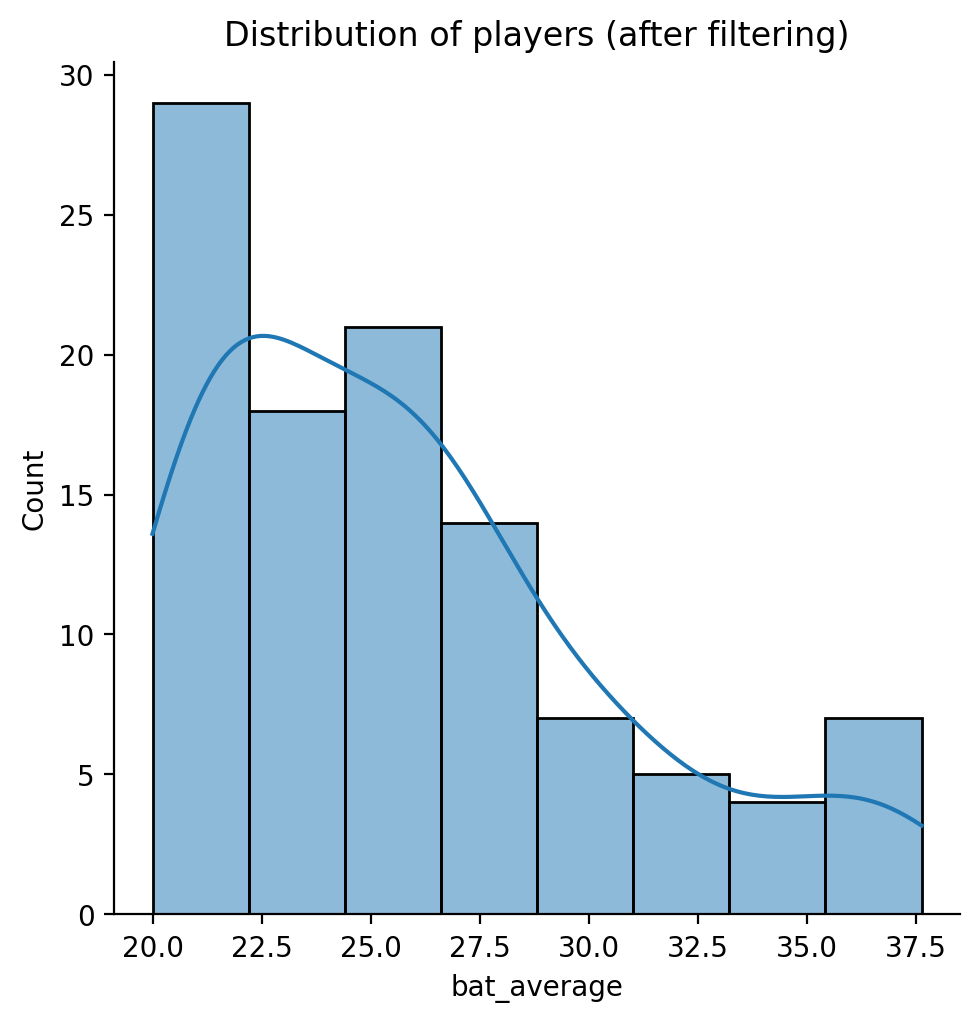

In [27]:
sns.displot(players['bat_average'],kde=True)
plt.title('Distribution of players (after filtering)')
plt.show()

In [28]:
players['bat_average'].describe()

count    105.000000
mean      25.801048
std        4.620541
min       20.000000
25%       21.950000
50%       24.940000
75%       27.930000
max       37.620000
Name: bat_average, dtype: float64

### **Scaling the data**

In [29]:
# Standard Scaler (mean = 0 and standard deviation = 1)
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,balls_bowled,wickets,overs,runs_conceded,bowl_econ
0,-1.180496,-1.136246,-1.174583,-1.124718,-1.128815,-0.958766,-1.115812,-0.261870,-0.286969,-0.259432,-0.228620,1.203281
1,-0.557527,-0.492258,-0.545731,-0.498462,-0.630718,-0.342900,0.273775,1.017407,0.907683,1.029753,0.962112,0.785982
2,1.707818,1.716335,1.741003,2.162444,1.650426,2.720641,1.147976,-0.439998,-0.419708,-0.443601,-0.448350,-0.905294
3,0.273100,0.196204,0.292738,0.253459,0.560386,0.462464,0.012820,-0.437299,-0.353339,-0.426858,-0.448350,-0.905294
4,-1.086107,-1.059751,-1.098358,-1.043003,-1.056627,-0.942975,0.012820,-0.288859,-0.419708,-0.292917,-0.289307,0.958200


In [30]:
players.insert(0, 'name', players.index)

In [31]:
NUM_CLUSTERS = 7
# Initialize few colour codes for each cluster
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']
  
# Show the top few players in each cluster (Players sorted on batting average)
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["bat_average"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col)['name',cluster_col].head(head_size))

In [32]:
def print_with_column_color_style(input_df):

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

    return input_df.style.apply(mycolor,axis=None)

In [33]:
def print_with_row_color_style(input_df, cluster_col):
    clusters = list(input_df[cluster_col].sort_values().unique())
    col_bgcolor_dict = dict(zip(clusters,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return [col_bgcolor_dict[x[cluster_col]]]*len(x)
    
    return input_df.style.apply(mycolor,axis=1)

### **K-Mean Clustering for Batting Average**

In [34]:
from sklearn.cluster import KMeans

# Define function to perform the kmeans clustering on the given data
def kmeans_clustering(num_clusters, max_iterations,input_df,output_df, output_col):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations)
    kmeans.fit(input_df)
    # assign the label to the output column
    output_df[output_col] = kmeans.labels_

In [36]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans'

# K-means clustering
kmeans_clustering(7,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

# View few entries from each cluster
groupby_cluster(kmeans_label,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,name,cluster_kmeans
0,JM Bairstow,0
1,LMP Simmons,0
2,HM Amla,0
9,KL Rahul,1
10,SE Marsh,1
11,MEK Hussey,1
35,SR Watson,2
36,JH Kallis,2
37,AD Russell,2
40,Salman Butt,3


In [40]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_data(cluster_col):
    

    # Sort players data based on no. of innings played
    #players.sort_values(["innings"], ascending = False,inplace=True)
    # Create column for each cluster and insert players in that cluster
    grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
    cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    print("PLAYERS IN EACH CLUSTER\n")
    display(print_with_column_color_style(cluster_df))
    
    #return cluster_summary, cluster_df

clustering_data(kmeans_label)

PLAYERS IN EACH CLUSTER



,0,1,2,3,4,5,6
0,CA Lynn,PA Patel,YK Pathan,EJG Morgan,SK Raina,RG Sharma,MK Tiwary
1,ML Hayden,MK Pandey,KA Pollard,Ishan Kishan,CH Gayle,V Kohli,F du Plessis
2,LMP Simmons,BB McCullum,SR Watson,M Vohra,Yuvraj Singh,MS Dhoni,BJ Hodge
3,JM Bairstow,M Vijay,JH Kallis,MS Bisla,DR Smith,RV Uthappa,DJ Hussey
4,HM Amla,V Sehwag,AD Russell,PP Shaw,JP Duminy,KD Karthik,SC Ganguly
5,D Padikkal,SV Samson,,Shubman Gill,,S Dhawan,N Rana
6,PD Collingwood,WP Saha,,HH Gibbs,,AB de Villiers,KS Williamson
7,RD Gaikwad,SA Yadav,,GC Smith,,G Gambhir,TM Dilshan
8,MN van Wyk,SPD Smith,,OA Shah,,AT Rayudu,CL White
9,,AJ Finch,,N Pooran,,DA Warner,RA Tripathi


PLAYERS CLUSTER SUMMARY


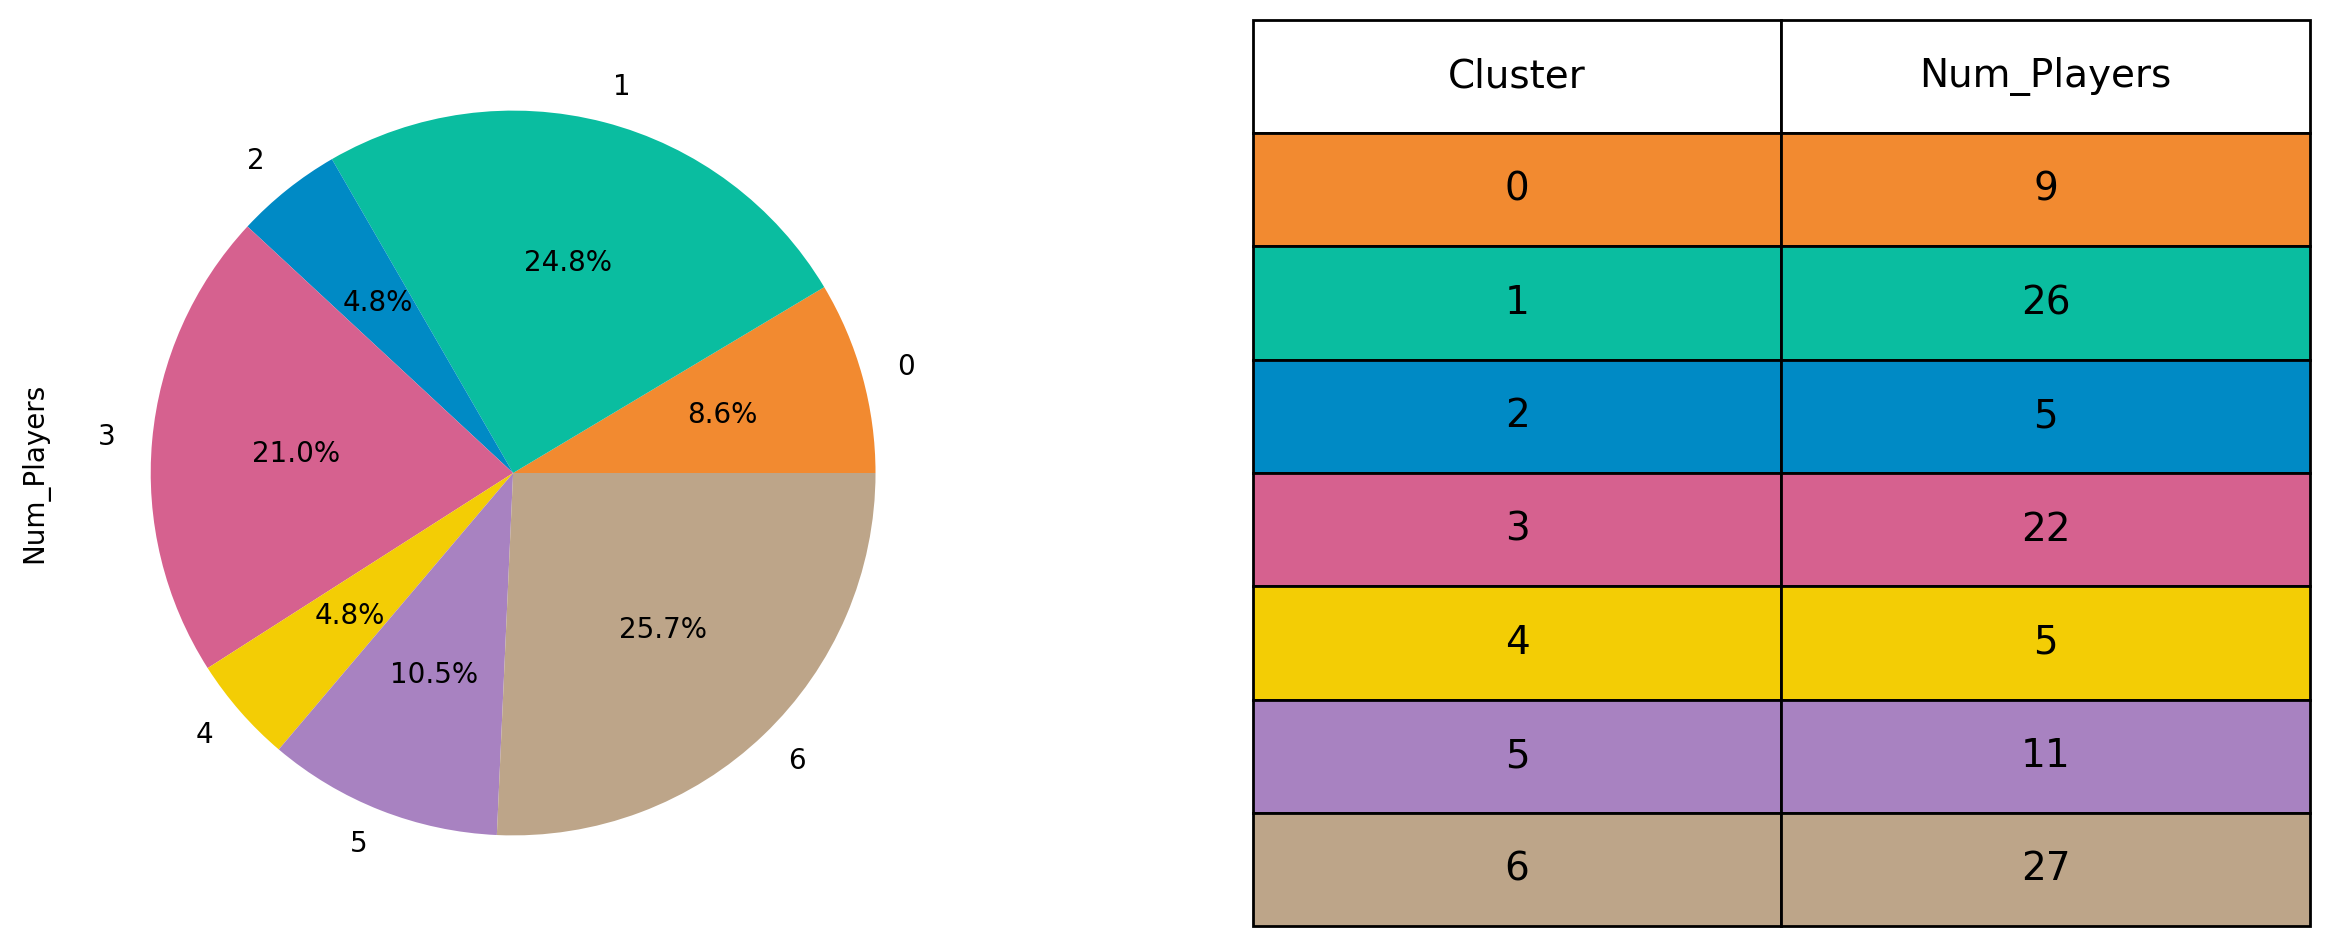

In [43]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_summary(cluster_col):
    
    # Create summary table for clusters
    cluster_summary = pd.DataFrame(players[cluster_col].value_counts().sort_index())
    cluster_summary.columns = ['Num_Players']
    cluster_summary.insert(0, 'Cluster', cluster_summary.index)
    
    # Plot pie-chart
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(121)
    cluster_summary['Num_Players'].plot.pie(autopct="%1.1f%%",  colors = CLUSTER_COLORS)
    
    print("PLAYERS CLUSTER SUMMARY")
    
    # Plot summary table

    #display(cluster_summary)
    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    
    # Set the row colours to match the cluster index
    colors = []
    num_columns = len(cluster_summary.columns)
    num_rows = len(cluster_summary.index)
    for i in range(num_rows):
        colors.append([CLUSTER_COLORS[i]] * num_columns)

    summary_plot_table = ax2.table(cellText=cluster_summary.values,cellColours=colors,
                         colLabels=cluster_summary.columns,bbox=bbox,loc='center',cellLoc='center' )

    summary_plot_table.auto_set_font_size(False)
    summary_plot_table.set_fontsize(font_size)

    plt.show()

# View the summary of the clustering
clustering_summary(kmeans_label)


# **K-Means Clutering for players in each cluster whose bowling economy is below 8.5 runs**

In [45]:
# restoring the data from backup
players = all_players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [48]:
# Cut off on bowling economy less than 8.5

# Current Analysis: Players who have a bowling economy of less than 8.5
CUTOFF_MATCHES = 8.5
players=players[players['bowl_econ']<CUTOFF_MATCHES]

In [49]:
players['bowl_econ'].describe()

count    399.000000
mean       4.451880
std        3.722414
min        0.000000
25%        0.000000
50%        6.800000
75%        7.755000
max        8.480000
Name: bowl_econ, dtype: float64

### **Scaling the data**

In [50]:
# Standard Scaler (mean = 0 and standard deviation = 1)
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players.insert(0, 'name', players.index)

In [51]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans for bowling economy'

# K-means clustering
kmeans_clustering(7,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

# View few entries from each cluster
groupby_cluster(kmeans_label,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,name,cluster_kmeans for bowling economy
0,JM Bairstow,0
1,HM Amla,0
2,RD Gaikwad,0
129,JH Kallis,1
130,KH Pandya,1
131,Shakib Al Hasan,1
163,AC Voges,2
164,JEC Franklin,2
165,Y Gnaneswara Rao,2
277,DA Warner,3


PLAYERS CLUSTER SUMMARY


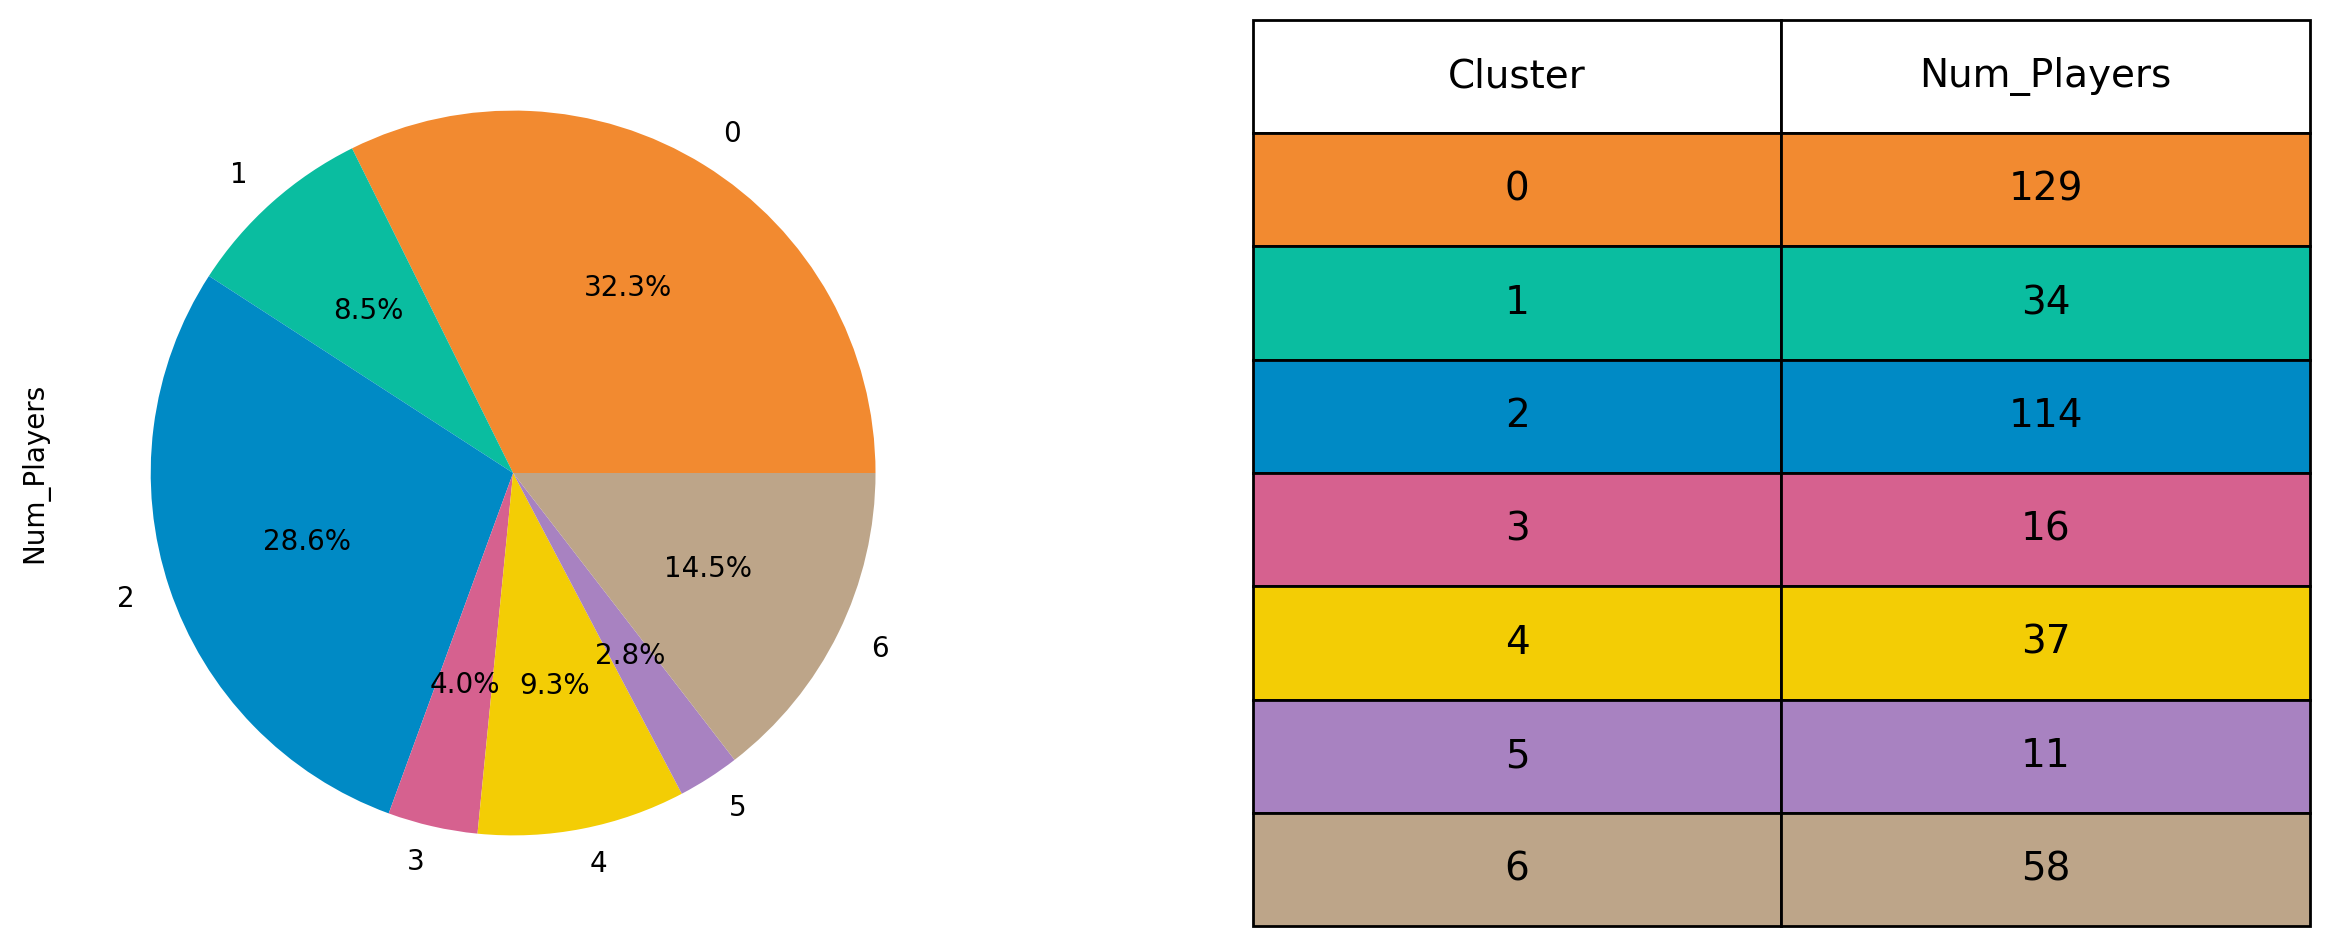

In [52]:
# View the summary of the clustering
clustering_summary(kmeans_label)

In [53]:
clustering_data(kmeans_label)

PLAYERS IN EACH CLUSTER



,0,1,2,3,4,5,6
0,MS Bisla,JH Kallis,M Manhas,RG Sharma,PA Patel,RA Jadeja,STR Binny
1,PP Shaw,IK Pathan,Gurkeerat Singh,SK Raina,BB McCullum,DJ Bravo,AM Nayar
2,Shubman Gill,AR Patel,SN Khan,MS Dhoni,M Vijay,Harbhajan Singh,MC Henriques
3,GJ Bailey,JA Morkel,GH Vihari,RV Uthappa,SV Samson,PP Chawla,DJ Hooda
4,HH Gibbs,KH Pandya,AL Menaria,KD Karthik,WP Saha,SP Narine,AD Mathews
5,GC Smith,R Bhatia,RN ten Doeschate,S Dhawan,NV Ojha,P Kumar,TL Suman
6,AP Tare,Shakib Al Hasan,JEC Franklin,AB de Villiers,SPD Smith,R Ashwin,A Symonds
7,MV Boucher,CH Morris,K Goel,YK Pathan,SA Yadav,A Mishra,P Negi
8,OA Shah,R Vinay Kumar,MN Samuels,G Gambhir,AJ Finch,B Kumar,DT Christian
9,M Kaif,KV Sharma,S Dube,AT Rayudu,MA Agarwal,UT Yadav,LR Shukla
